In [ ]:
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Generacion comando txt cortar toda roi

In [ ]:
%cd"/content/gdrive/MyDrive/memoria/"
!ls
#el comando ls deberia mostrar la imagen grande y el jupyterNotebook

/content/gdrive/MyDrive/memoria
 comandos_terminal.txt		   ejemplo_x2.5_z0.tif
 ejemplo.ndpi			   ejemplo_x5_z0.tif
 ejemplo_rois_dibujadas.tif	   ejemplo.xml
 ejemplo_rois_dibujadas_x2.5.tif  'estado 28 5 2021.gdoc'
 ejemplo_rois_dibujadas_x5.tif	   jueves22
 ejemplo_x0.625_z0.tif		   pre-resumen.gdoc
 ejemplo_x1.25_z0.tif		  'topicos de presentación avance 4 junio.gdoc'


In [ ]:
def read_xml(ndpa_path):
    tree = ET.parse(ndpa_path)
    root = tree.getroot()
    anotaciones=root.findall(".//ndpviewstate")
    anotaciones_ndpiycolores=[]    

    anotaciones_ndpi=[]
    colores_roi = []
    for anotacion in anotaciones:
        color_roi = anotacion[10].attrib['color']
        l_aux=[]
        x_ndpi = int(anotacion[10][0].text)
        y_ndpi = int(anotacion[10][1].text)
        l_aux.append(x_ndpi)
        l_aux.append(y_ndpi)
        radio_ndpi = anotacion[10][2].text
        if radio_ndpi != 'pinred':#POR CORREGIR: casos donde el pin sea de otro color, ejemplo azul seria un pinblue
            radio_ndpi = int(radio_ndpi)
            l_aux.append(radio_ndpi)
            anotaciones_ndpi.append(l_aux)
            colores_roi.append(color_roi)

    anotaciones_ndpiycolores.append(anotaciones_ndpi)
    anotaciones_ndpiycolores.append(colores_roi)
    return anotaciones_ndpiycolores

In [ ]:
def transformacion_color2clase(colores_roi):
    mapeo_color2clase = {'#ff00ff' : '3+', 
                   '#0000ff' : '2+', 
                   '#ff0000' : '1+',
                   '#00ff00' : '0',
                   '#ffff00' : '0', 
                   '#000000' : 'no-tumor',
                   } 
    clases_roi = []
    for color in colores_roi:
        clases_roi.append(mapeo_color2clase[color])
    return clases_roi

def transformacion_clase2color(clases_roi):
    mapeo_clases2color = {'3+':'#ff00ff', 
                          '2+':'#0000ff',
                          '1+':'#ff0000',               
                          '0':'#00ff00',#CLASE 0 SIEMPRE LOS TIRARA A VERDE
                          '0':'#ffff00',
                          'no-tumor':'#000000'
                        } 
    colors_roi = []
    for clase in clases_roi:
        colors_roi.append(mapeo_clases2color[clase])
    return colors_roi

In [ ]:
def transformacion_ndpi2pixeles(anotaciones_ndpi):
    anotaciones_pixeles=[]
    for anotacion in anotaciones_ndpi:
        list_aux=[]
        x_ndpi = anotacion[0]
        y_ndpi = anotacion[1]
        x_pixeles = int((x_ndpi + 10010504)/227)
        y_pixeles = int((y_ndpi + 11736845)/227)
        radius = anotacion[2]
        radio_pixeles =int(radius/227)#forzamos que sea int porque son pixeles
        list_aux.append(x_pixeles)
        list_aux.append(y_pixeles)
        list_aux.append(radio_pixeles)
        anotaciones_pixeles.append(list_aux)
    return anotaciones_pixeles

def esquinas_cuadrado_roi(anotaciones_pixeles):
    contenedor_esquinayladocuadrado=[]
    for anotacion in anotaciones_pixeles:
        esquinayladocuadrado=[]
        x_roi = anotacion[0]
        y_roi = anotacion[1]
        radio = anotacion[2]
        lado_cuadrado = int(radio * math.sqrt(2)) 
        esq_sup_izq =[int(x_roi - radio/math.sqrt(2)),int(y_roi + radio/math.sqrt(2))]
        esquinayladocuadrado.append(esq_sup_izq)
        esquinayladocuadrado.append(lado_cuadrado)
        contenedor_esquinayladocuadrado.append(esquinayladocuadrado)
    return contenedor_esquinayladocuadrado

def comandos_terminal_ndpisplit_cuadrado_roi(contenedor_esquinayladocuadrado,clases_roi):
    comandos=[]
    ID_anotacion = 0
    for eyl in contenedor_esquinayladocuadrado: 
        x_sup_izq = str(eyl[0][0])
        y_sup_izq = str(eyl[0][1])
        ancho_parche = str(eyl[1])
        largo_parche = str(eyl[1])
        clase_roi = clases_roi[ID_anotacion]#ya es str
        ID_parche = 'a'+str(ID_anotacion) + '_clase_'+clase_roi                
        comandos.append('ndpisplit -Ex40,z0,'+ x_sup_izq +','+ y_sup_izq +','+ ancho_parche +','+ largo_parche +','+ ID_parche +' -K ejemplo.ndpi')
        #print('ndpisplit -Ex40,z0,0,0,'+str(int(esquina[0]))+','+str(int(esquina[1]))+',mylabel -K ejemplo.ndpi')
        ID_anotacion +=1    
    return comandos

def save_comandos_txt(comandos_ndpi):
    with open('comandos_terminal.txt', "w") as f:
        for comando in comandos_ndpi:
            f.write(str(comando) +"\n")

            

se ejecutan los comando txt en el computador y se ejecuta el macro para extrar los canales H y canal DAB. luego se suben a google drive y se procesa en las siguientes celdas.

# features extraction H DAB

In [ ]:
def sort_especial(paths_list):
    a=[]
    for l in paths_list:
        #print(l)
        #print('l_aux',l_aux)
        ID_anotacion = int(l.split('_')[3][1:])
        #print(ID_anotacion)
        #print(l_aux)       
        b=[]
        b.append(ID_anotacion)
        b.append(l)
        a.append(b)
        #print('-----------------------')
    path_sorted=sorted(a, key=lambda x:x[0])

    path_final=[]
    [path_final.append(path[1]) for path in path_sorted]
    return path_final

In [ ]:
#encontrar los paths de las imagenes H y DAB
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
base_path_DAB = "/content/gdrive/MyDrive/memoria/jueves22/canalDAB/"

canalH_paths=[]
canalDAB_paths=[]
[canalH_paths.append(img_path) for img_path in os.listdir(base_path_H)]
[canalDAB_paths.append(img_path) for img_path in os.listdir(base_path_DAB)]

canalH_paths = sort_especial(canalH_paths)#despues aplicar lo de hacerlo en forma de funcion que modifique el orden de la lista
canalDAB_paths = sort_especial(canalDAB_paths)
print(canalH_paths)
print(canalDAB_paths)


['ejemplo_x40_z0_a0_clase_3+.png-H.tif', 'ejemplo_x40_z0_a1_clase_2+.png-H.tif', 'ejemplo_x40_z0_a2_clase_0.png-H.tif', 'ejemplo_x40_z0_a3_clase_3+.png-H.tif', 'ejemplo_x40_z0_a4_clase_0.png-H.tif', 'ejemplo_x40_z0_a5_clase_0.png-H.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a9_clase_0.png-H.tif', 'ejemplo_x40_z0_a10_clase_2+.png-H.tif', 'ejemplo_x40_z0_a11_clase_2+.png-H.tif', 'ejemplo_x40_z0_a12_clase_2+.png-H.tif', 'ejemplo_x40_z0_a13_clase_1+.png-H.tif', 'ejemplo_x40_z0_a14_clase_2+.png-H.tif']
['ejemplo_x40_z0_a0_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a1_clase_2+.png-DAB.tif', 'ejemplo_x40_z0_a2_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a3_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a4_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a5_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.

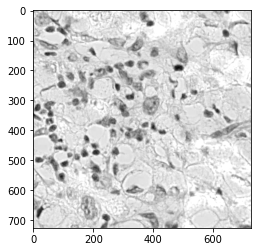

In [ ]:
import numpy as np
from matplotlib.pyplot import imshow, subplot, plot
from  skimage import filters, morphology, io, img_as_uint, measure
import scipy.ndimage as snd
img_path = canalH_paths[0]
image = io.imread(base_path_H+img_path)
imshow(image, cmap='gray')

## get threshold using kmeans (k=2)

Threshold=195.389105


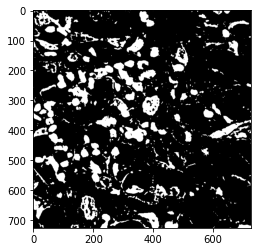

In [ ]:
import numpy as np
from matplotlib.pyplot import imshow
from skimage import filters, morphology, io, img_as_uint
from sklearn.cluster import KMeans


def mythreshold(image):#ESTO SE PUEDE REEMPLAZAR POR LO DE FILTER OTSU
    
    X=image.flatten().reshape(-1,1)
    #how many clusters?
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    
    #SOLUTION for 2 clusters
    threshold=kmeans.cluster_centers_[0] + (kmeans.cluster_centers_[1]-kmeans.cluster_centers_[0])/2.0
    print("Threshold=%f" % threshold)
    return threshold

image = io.imread(base_path_H+img_path)
threshold = mythreshold(image)

binary=image<threshold#esto es lo de la indexacion

imshow(binary, cmap='gray')

## siento que el umbral de otsu es mas rapido

threshold= 195


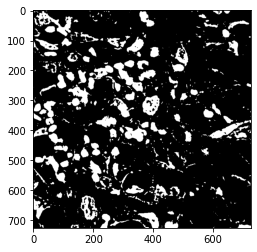

In [ ]:
#from curso de mi profe guia, es la idea equivalente a otsu
from skimage import data, filters, measure, morphology

image = io.imread(base_path_H+img_path)

threshold = filters.threshold_otsu(image)
print('threshold=',threshold)

binary=image<threshold#esto es lo de la indexacion

imshow(binary, cmap='gray')

In [ ]:
all_labels = measure.label(binary, background=0)

properties = measure.regionprops(all_labels)#<--- esto equivale a coneccted components, viene de skimage



In [ ]:
['4' for i in properties[0].coords]

['4', '4', '4', '4']

In [ ]:
#type(properties[0])
#properties es una lista de objetos:'RegionProperties', cada uno es una celula, tiene los atributos de la celula

skimage.measure._regionprops.RegionProperties

In [ ]:
from skimage.color import rgb2gray
from skimage import data, filters, measure, morphology
HDAB=[]
H_features=[]
lista_properties=[]
for img_path in canalH_paths:
    image = io.imread(base_path_H+img_path)
    print(image.shape)
    H_gray = rgb2gray(image)
    threshold = filters.threshold_otsu(image)
    #thresholds_otsu.append(threshold)#lo guardo para usarlo en el segundo for, mismo umbrales saran la misma cantidad de celulas a las que extraer features
    #threshold = mythreshold(image)
    img_binary=image<threshold
    #lista_mascaras.append(img_binary)
    #imshow(binary, cmap='gray')
    all_labels = measure.label(img_binary, background=0)
    properties_previo = measure.regionprops(all_labels)#properties es una lista de regionprops
    properties=[]
    [properties.append(propertie) for propertie in properties_previo if propertie.area > 10 ]#para filtrar las areas muy chiquiticas

    
    
    lista_properties.append(properties)
    H_anotation=[]
    
    for celula_propertie in properties:
            for coord in celula_propertie.coords: # este for es el que tiene que sacar los featuers solo de  los pixeles en con valor 1
                if coord[0]>image.shape[0] or coord[0]>image.shape[0]:
                    print('salio una coordenada muy grande')
                H_anotation.append(H_gray[coord[0],coord[1]])
            
    H_features.append(H_anotation)        
HDAB.append(H_features)    
#print('thresholds_otsu=',thresholds_otsu)
print('----------------------------------------')
print('len(propertie[0])=',len(lista_properties[0]))

#############################################################
#'''
DAB_features=[]
i=0
for img_path in canalDAB_paths:
    image = io.imread(base_path_DAB+img_path)
    print(image.shape)
    DAB_gray = rgb2gray(image)
    #por otimizar el clculo de ese trheshols
    #threshold = thresholds_otsu[i]#tengo que usar el mismo threshold de la imagen que se calculo del canal H
    #print('use el umbral:', threshold)
    #i+=1
    #threshold = mythreshold(image)
    #img_binary=image<threshold # el mismo umbral con distinta imagen siempre va a dar difernetes celulas, 
    #entonces, hay que usar la mascara generada en H sobre las celulas de la imagen DAB, no es necesario calcular el umbral
    #se puede guardar una lista de mascaras.
    # de hecho podria huardar los objetos labels.  queda mas claro guardando las mascaras
    #img_binary = lista_mascaras[i]
    
    #all_labels = measure.label(img_binary, background=0)
    #properties = measure.regionprops(all_labels)
    DAB_anotation=[]
    for celula_propertie in lista_properties[i]:
        for coord in celula_propertie.coords: # este for es el que tiene que sacar los featuers solo de  los pixeles en con valor 1
                DAB_anotation.append(DAB_gray[coord[1],coord[0]])#hay un problema con el prpeti queestoy usando
    i+=1
    DAB_features.append(DAB_anotation)        
#############################################################
HDAB.append(DAB_features)    

clases_roi=[]
[clases_roi.append(img_path.split('_')[5].split('.')[0]) for img_path in canalH_paths]
colores_roi = transformacion_clase2color(clases_roi)
HDAB.append(colores_roi)   
HDAB.append(clases_roi) 


#'''


(725, 725)
(972, 972)
(1419, 1419)
(578, 578)
(654, 654)
(1016, 1016)
(1473, 1473)
(2481, 2481)
(1428, 1428)
(1030, 1030)
(1866, 1866)
(1045, 1045)
(494, 494)
(1978, 1978)
(1409, 1409)
----------------------------------------
len(propertie[0])= 331
(725, 725)
(972, 972)
(1419, 1419)
(578, 578)
(654, 654)
(1016, 1016)
(1473, 1473)
(2481, 2481)
(1428, 1428)
(1030, 1030)
(1866, 1866)
(1045, 1045)
(494, 494)
(1978, 1978)
(1409, 1409)


In [ ]:
type(lista_properties[0][1])

skimage.measure._regionprops.RegionProperties

In [ ]:
print(len(HDAB[0][1]))
print(len(HDAB[1][1]))


154904
154904


## Scatter plot

In [ ]:
plt.rcParams['axes.labelsize']=60
plt.rcParams['xtick.labelsize']=50    #tamaño de los numeros del eje X
plt.rcParams['ytick.labelsize']=50    #tamaño de los numeros del eje Y
plt.rcParams['xtick.color']='magenta'        #color numenos eje X
plt.rcParams['ytick.color']='magenta'      #color numenos eje Y
plt.rcParams['axes.labelcolor']='magenta'  #color de los nombres de los ejes
plt.rcParams['axes.grid']=True            #por defecto, printear la grilla

Graficos tienen una linea en 190 porque se binariza con la mascara del canal H y el umbral es en torno als 200

<Figure size 432x288 with 0 Axes>

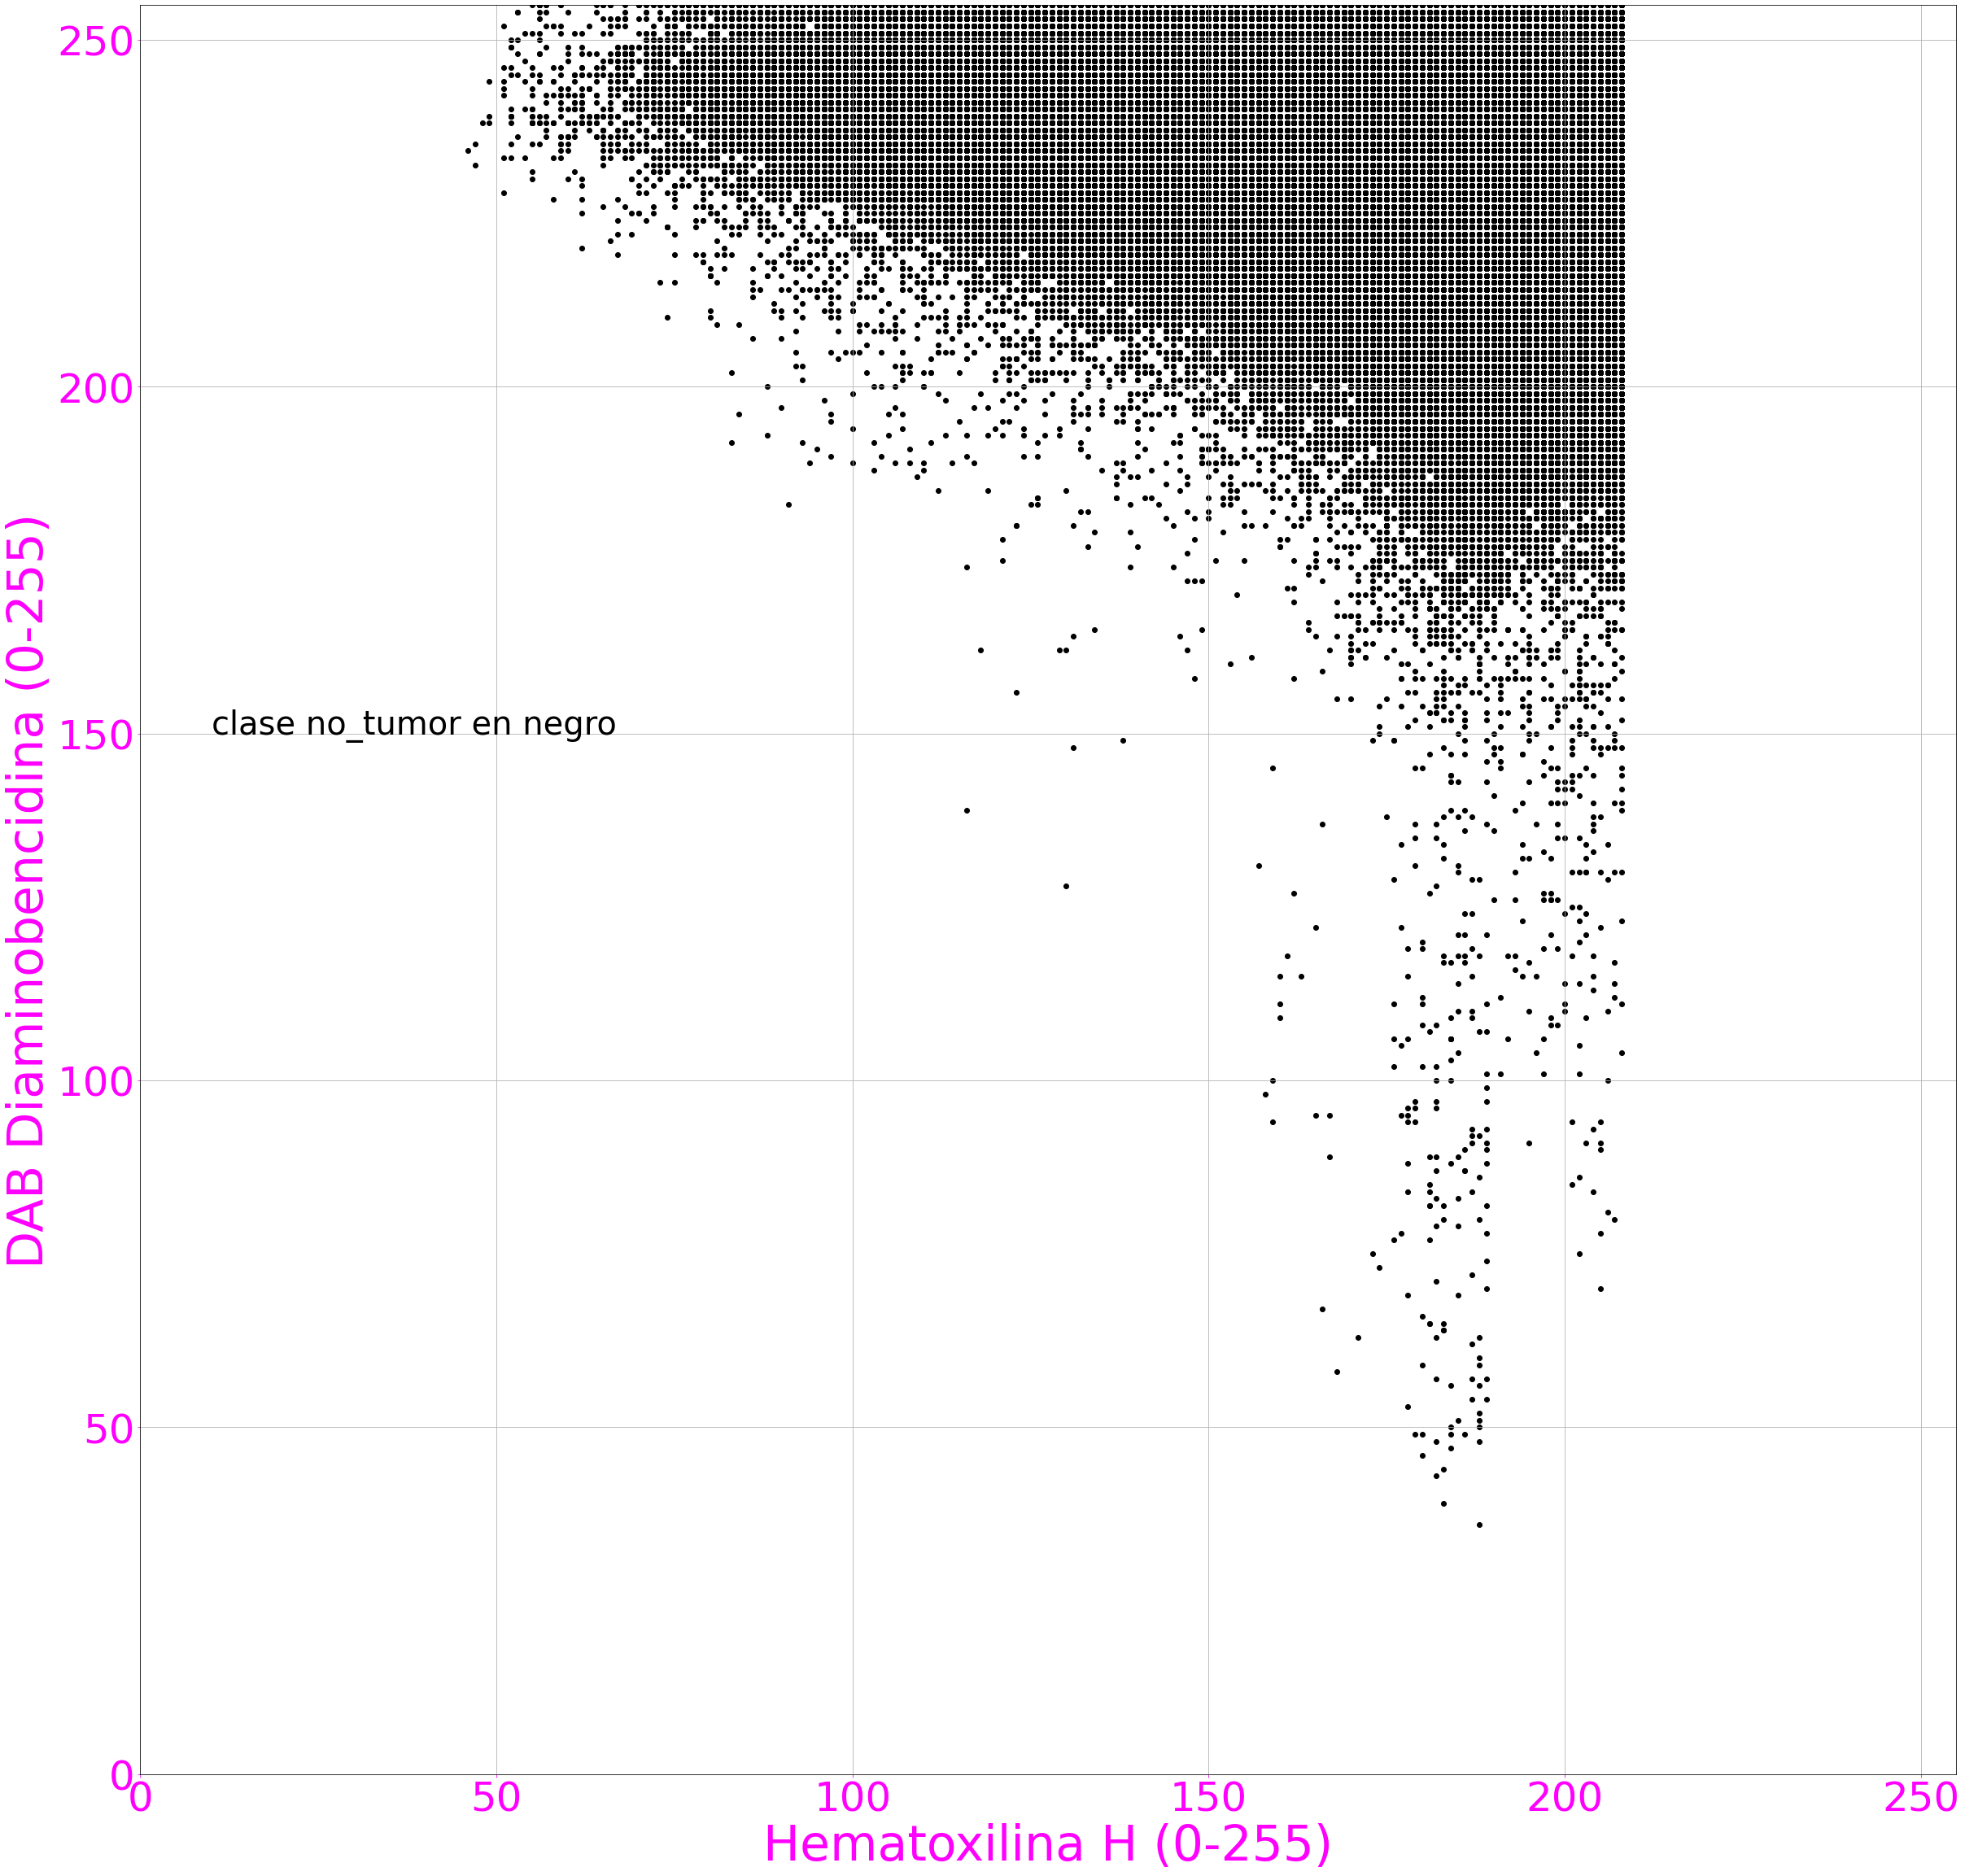

In [ ]:
#vizualizacion

import pandas as pd
import matplotlib.pyplot as plt       

plt.clf()
fig, ax = plt.subplots(figsize=(40,40))
ax.set(xlim=(0, 255), ylim=(0, 255))

try:#cada ax.scatter plotea los pixeles de una anotacion
    #plt.text(10, 150, 'clase 3+ en magenta',fontsize=40)
    #ax.scatter(HDAB[0][0] , HDAB[1][0], color= HDAB[2][0] )#clase: 3+ MAGENTA
    #ax.scatter(HDAB[0][3] , HDAB[1][3], color= HDAB[2][3] )#clase: 3+ MAGENTA
    
    #plt.text(10, 150, 'clase 2+ en azul',fontsize=40)
    #ax.scatter(HDAB[0][1] , HDAB[1][1], color= HDAB[2][1] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][10] , HDAB[1][10], color= HDAB[2][10] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][11] , HDAB[1][11], color= HDAB[2][11] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][12] , HDAB[1][12], color= HDAB[2][12] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][14] , HDAB[1][14], color= HDAB[2][14] )#clase: 2+ AZUL

    #plt.text(10, 150, 'clase 1+ en rojo',fontsize=40) 
    #ax.scatter(HDAB[0][13] , HDAB[1][13], color= HDAB[2][13] )#clase: 1+ ROJO
    
    #plt.text(10, 150, 'clase 0+ en amarillo',fontsize=40) 
    #ax.scatter(HDAB[0][2] , HDAB[1][2], color= HDAB[2][2] )#clase: 0 VERDE (O AMARILLO)
    #ax.scatter(HDAB[0][4] , HDAB[1][4], color= HDAB[2][4] )#clase: 0 VERDE (O AMARILLO)
    #ax.scatter(HDAB[0][5] , HDAB[1][5], color= HDAB[2][5] )#clase: 0 VERDE (O AMARILLO)
    #ax.scatter(HDAB[0][9] , HDAB[1][9], color= HDAB[2][9] )#clase: 0 VERDE (O AMARILLO)
    
    plt.text(10, 150, 'clase no_tumor en negro',fontsize=40) 
    ax.scatter(HDAB[0][6] , HDAB[1][6], color= HDAB[2][6] )#clase: no_tumor NEGRO 
    ax.scatter(HDAB[0][7] , HDAB[1][7], color= HDAB[2][7] )#clase: no_tumor NEGRO
    ax.scatter(HDAB[0][8] , HDAB[1][8], color= HDAB[2][8] )#clase: no_tumor NEGRO
    

except:
    pass
#legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="clases")
#ax.add_artist(legend1)

ax.set_xlabel('Hematoxilina H (0-255)')
ax.set_ylabel('DAB Diaminobencidina (0-255)')
plt.show()




## construyendo el Kmeans

In [ ]:
print(HDAB[3])

['3+', '2+', '0', '3+', '0', '0', 'no-tumor', 'no-tumor', 'no-tumor', '0', '2+', '2+', '2+', '1+', '2+']


In [ ]:
#calculando los centroides de las clases
centroide_H=[]#largo 5 porque son 5 clases
for async in HDAB[0]:
